# 부산광역시 쓰레기 배출량 예측 pt.2

---

<br>

## 00. 기본 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

# 경고 메시지는 출력 X
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 한글 font 설정

import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin':           # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':        # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

<Axes: title={'center': '한글타이틀'}>

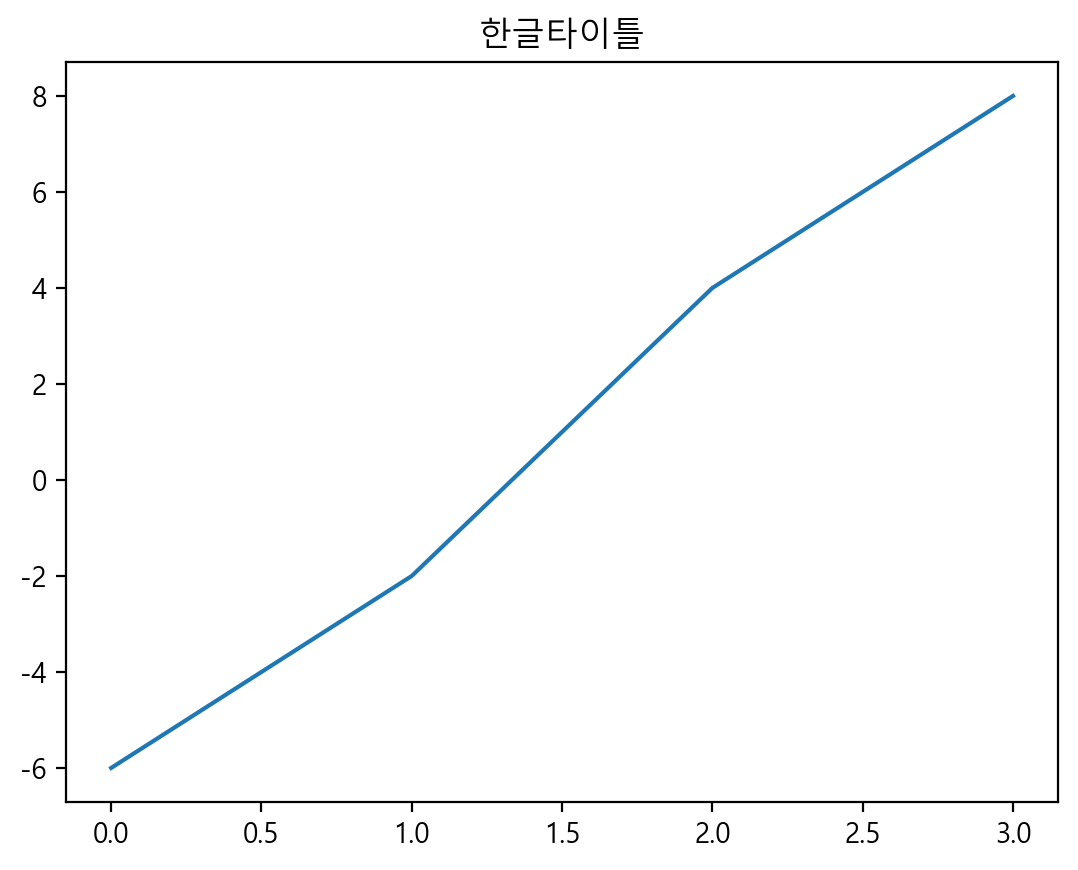

In [4]:
# 한글폰트와 마이너스 폰트 설정 확인

pd.Series([-6, -2, 4, 8]).plot(title="한글타이틀")

<br><br>

---

## 01. 데이터 로드

In [5]:
df = pd.read_csv("merged_df.csv", encoding="cp949")

print(f"df shape: {df.shape}")
df.head()

df shape: (1387, 18)


,지역,연도,시ㆍ도,시군구,배출량(톤/년),세대수,총인구수 (명),single_1인가구비율,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
0,서울_종로구,2024,서울,종로구,31941.99,72166.0,138336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,서울_중구,2024,서울,중구,39154.08,64995.0,120544.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,서울_용산구,2024,서울,용산구,31272.54,103241.0,203854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,서울_성동구,2024,서울,성동구,25274.96,131953.0,273669.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,서울_광진구,2024,서울,광진구,25437.48,169931.0,331963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br><br>

---

## 02. '19 - '23 데이터만 사용 + 결측치 제거

In [6]:
# 24년 제외하고 나머지 데이터만 추출
df_23 = df[df['연도'] != 2024]

print(f"df except 2024 shape: {df_23.shape}")

df except 2024 shape: (1156, 18)


In [7]:
# NaN 여부
is_null = df_23.isnull()

# 0.0 여부 (숫자형 컬럼에 대해만 적용 — 여기서는 '배출량(톤/년)'만 우선 적용함)
is_zero = df_23[['배출량(톤/년)', '세대수', '총인구수 (명)']].apply(lambda x: x == 0.0)

# 행 기준으로 NaN 또는 0.0 값이 하나라도 있으면 True
null_or_zero_rows = is_null.any(axis=1) | is_zero.any(axis=1)

# 해당 행만 추출
df_with_nulls_or_zeros = df_23[null_or_zero_rows]

# 결과 확인
print(f"NaN 또는 0.0 값이 있는 행 수: {df_with_nulls_or_zeros.shape[0]}")
print(f"NaN 또는 0.0 값이 있는 지역: \n{df_with_nulls_or_zeros['지역'].unique()}")

df_with_nulls_or_zeros.head(3)

NaN 또는 0.0 값이 있는 행 수: 85
NaN 또는 0.0 값이 있는 지역: 
['대구_군위군' '강원_속초시' '강원_양구군' '충남_서산시' '충남_홍성군' '전북_남원시' '전북_순창군' '전북_고창군'
 '전남_보성군' '전남_강진군' '전남_해남군' '경북_김천시' '경북_안동시' '경북_영천시' '경남_진주시' '경남_남해군'
 '강원_평창군' '경북_예천군' '전북_군산시' '경북_남구' '경북_북구' '부산_군위군']


,지역,연도,시ㆍ도,시군구,배출량(톤/년),세대수,총인구수 (명),single_1인가구비율,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
278,대구_군위군,2023,대구,군위군,4130.99,13588.0,22988.0,0.285,0.8831,0.0572,0.0146,0.0299,0.0153,NaN,NaN,NaN,NaN,NaN
341,강원_속초시,2023,강원,속초시,NaN,41330.0,82054.0,0.357,0.2021,0.7239,0.0457,0.0131,0.0153,0.3879,0.3297,0.1645,0.0915,0.0264
350,강원_양구군,2023,강원,양구군,NaN,10544.0,21056.0,0.310,0.5810,0.3256,0.0409,0.0205,0.0320,0.3619,0.3357,0.1627,0.1021,0.0376


In [8]:
# NaN 또는 0.0 값이 있는 지역 전체 삭제
df_cleaned = df_23[~df_23['지역'].isin(df_with_nulls_or_zeros['지역'].unique())]

print(f"결측치 제거 후 df_cleaned shape: {df_cleaned.shape}")
df_cleaned.head(3)

# 기존 (1156, 18)

결측치 제거 후 df_cleaned shape: (1054, 18)


,지역,연도,시ㆍ도,시군구,배출량(톤/년),세대수,총인구수 (명),single_1인가구비율,단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
229,서울_종로구,2023,서울,종로구,36717.63,72067.0,139417.0,0.407,0.2471,0.3466,0.1179,0.2700,0.0184,0.4547,0.2510,0.1626,0.1018,0.0298
230,서울_중구,2023,서울,중구,48405.22,64714.0,121312.0,0.437,0.1298,0.6365,0.0424,0.1725,0.0188,0.4774,0.2610,0.1507,0.0864,0.0245
231,서울_용산구,2023,서울,용산구,32672.16,107825.0,213151.0,0.394,0.1720,0.5121,0.0504,0.2570,0.0085,0.4321,0.2707,0.1686,0.1004,0.0282


<br><br>

---

## +) single_1인가구비율 col 삭제

In [20]:
df_drop = df_cleaned.drop("single_1인가구비율", axis=1)
df_drop.head(3)

,지역,연도,시ㆍ도,시군구,배출량(톤/년),세대수,총인구수 (명),단독주택비율,아파트비율,연립주택비율,다세대주택비율,비주거용주택비율,1인가구비율,2인가구비율,3인가구비율,4인가구비율,5인이상가구비율
229,서울_종로구,2023,서울,종로구,36717.63,72067.0,139417.0,0.2471,0.3466,0.1179,0.2700,0.0184,0.4547,0.2510,0.1626,0.1018,0.0298
230,서울_중구,2023,서울,중구,48405.22,64714.0,121312.0,0.1298,0.6365,0.0424,0.1725,0.0188,0.4774,0.2610,0.1507,0.0864,0.0245
231,서울_용산구,2023,서울,용산구,32672.16,107825.0,213151.0,0.1720,0.5121,0.0504,0.2570,0.0085,0.4321,0.2707,0.1686,0.1004,0.0282


<br><br>

---
## 04. 시각화

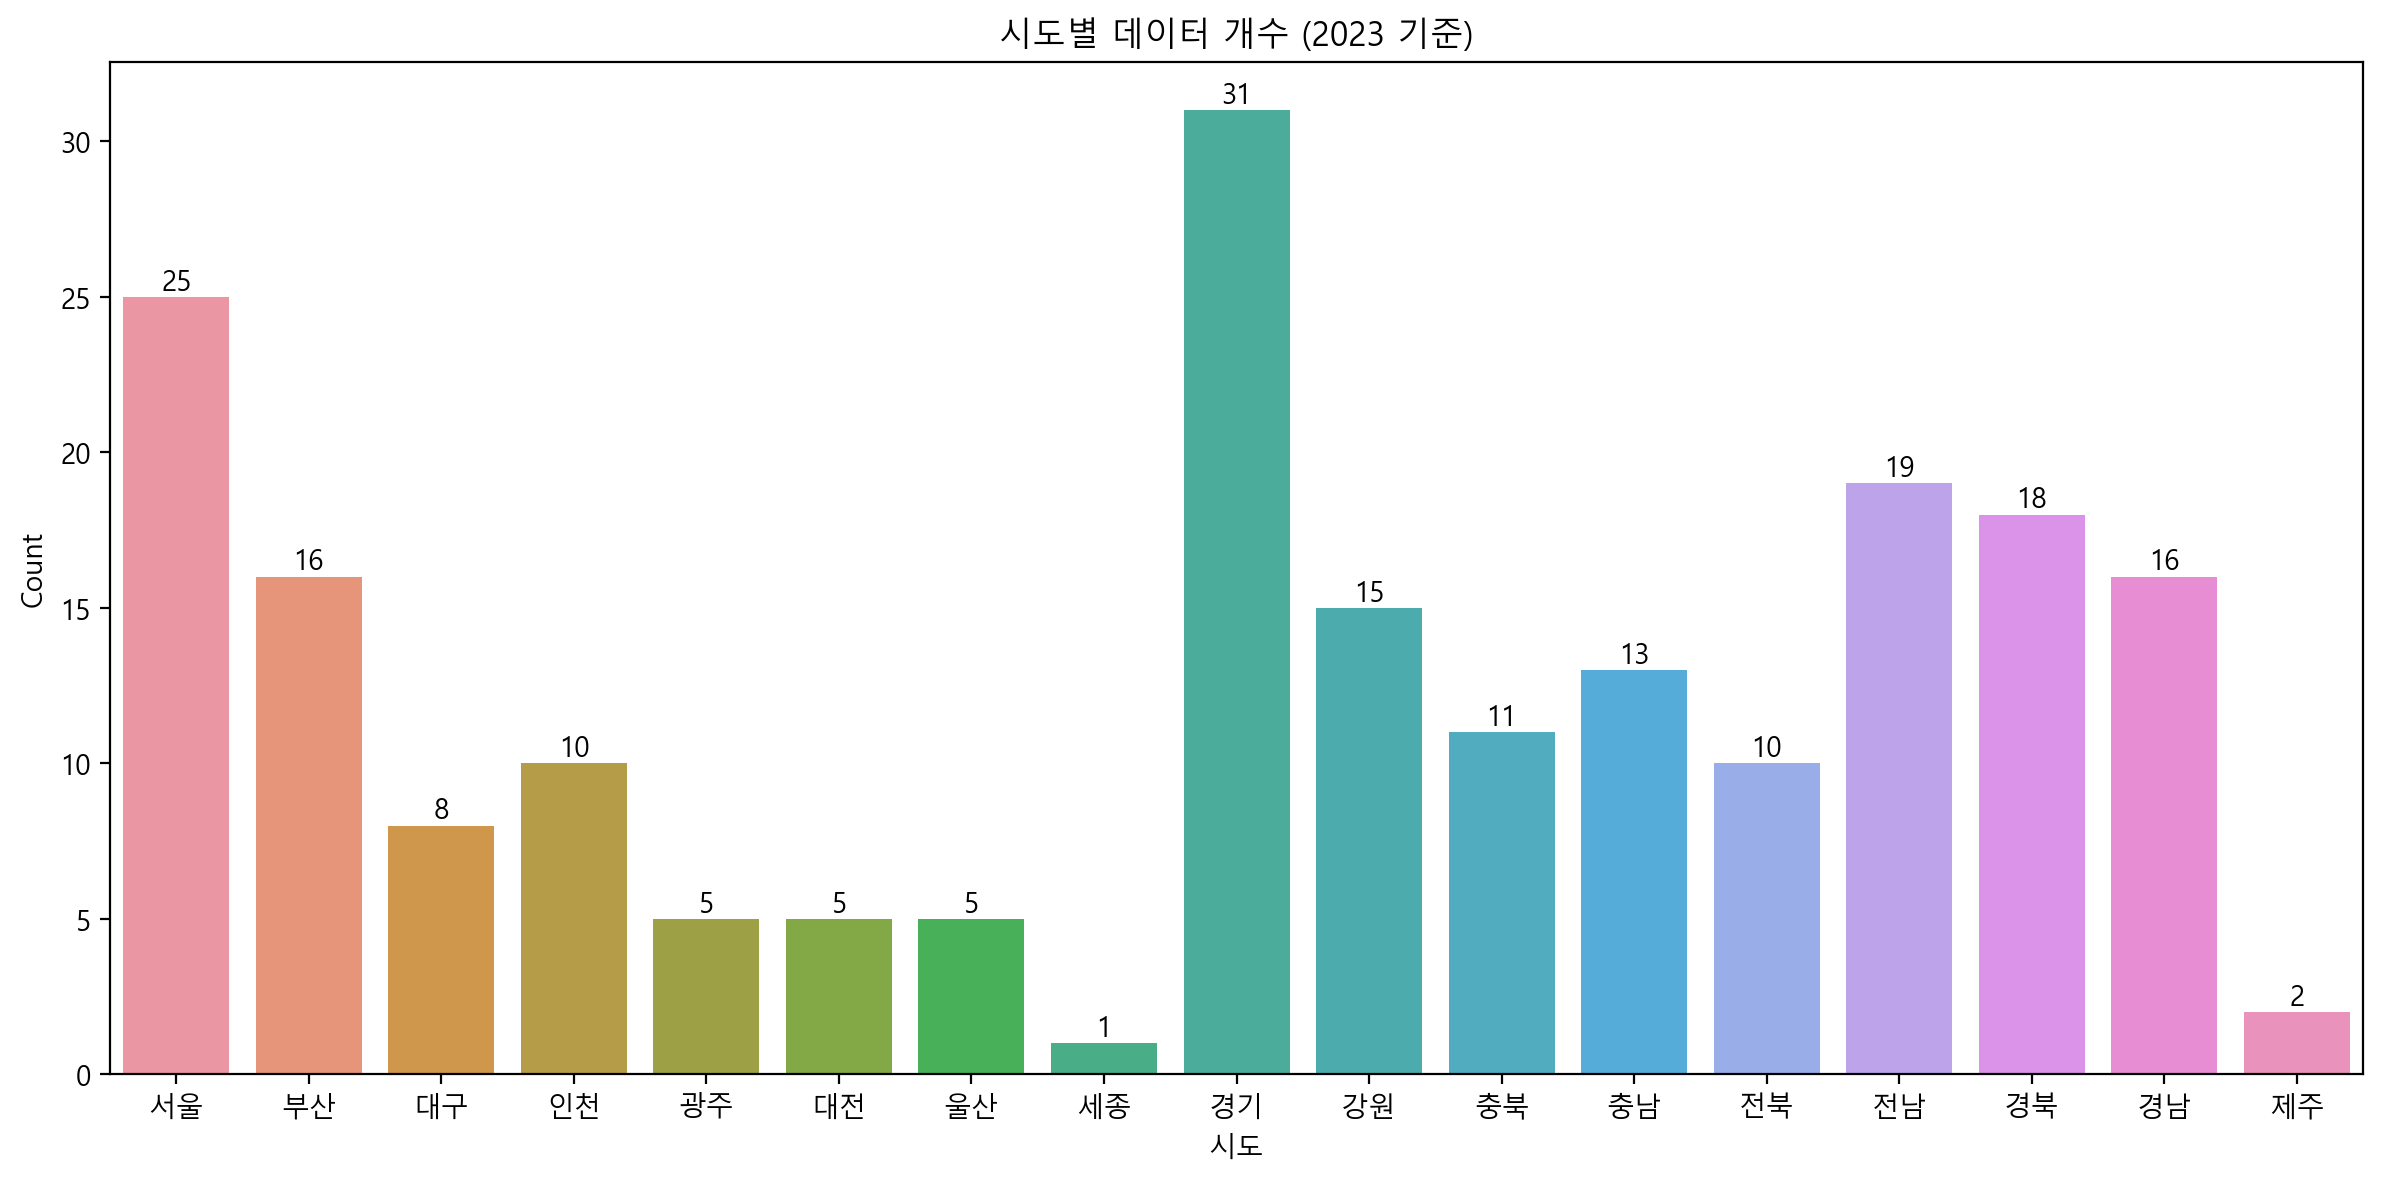

In [21]:
# 시도별 countplot
df23 = df_drop[df_drop['연도'] == 2023]

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df23, x='시ㆍ도')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.title('시도별 데이터 개수 (2023 기준)')
plt.xlabel('시도')
plt.ylabel('Count')
plt.tight_layout()

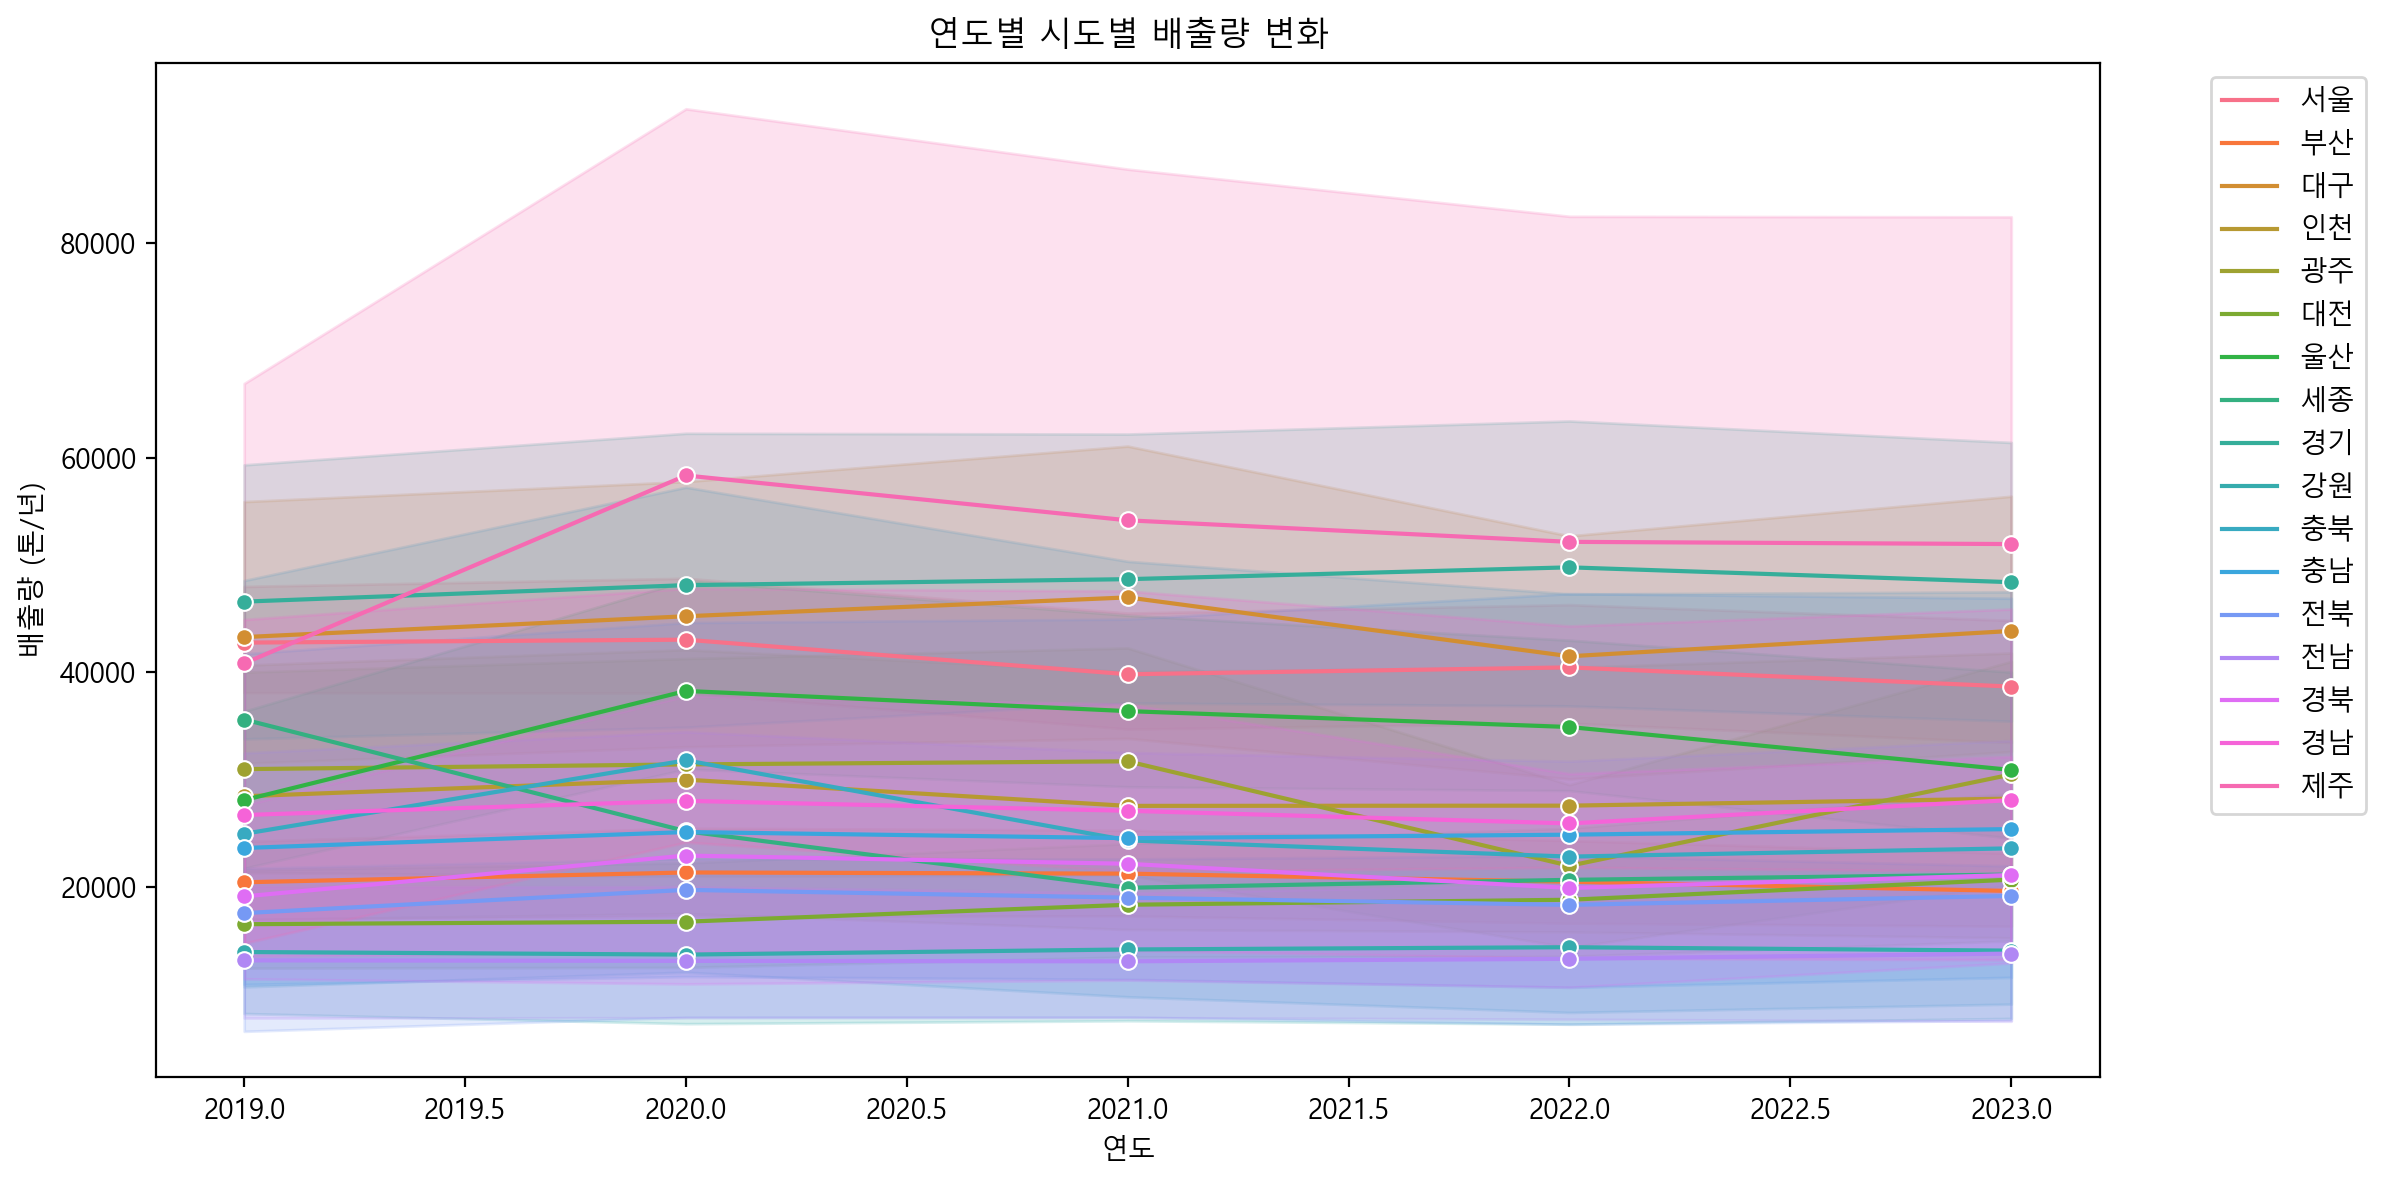

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_drop, x='연도', y='배출량(톤/년)', hue='시ㆍ도', marker='o')

plt.title('연도별 시도별 배출량 변화')
plt.xlabel('연도')
plt.ylabel('배출량 (톤/년)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

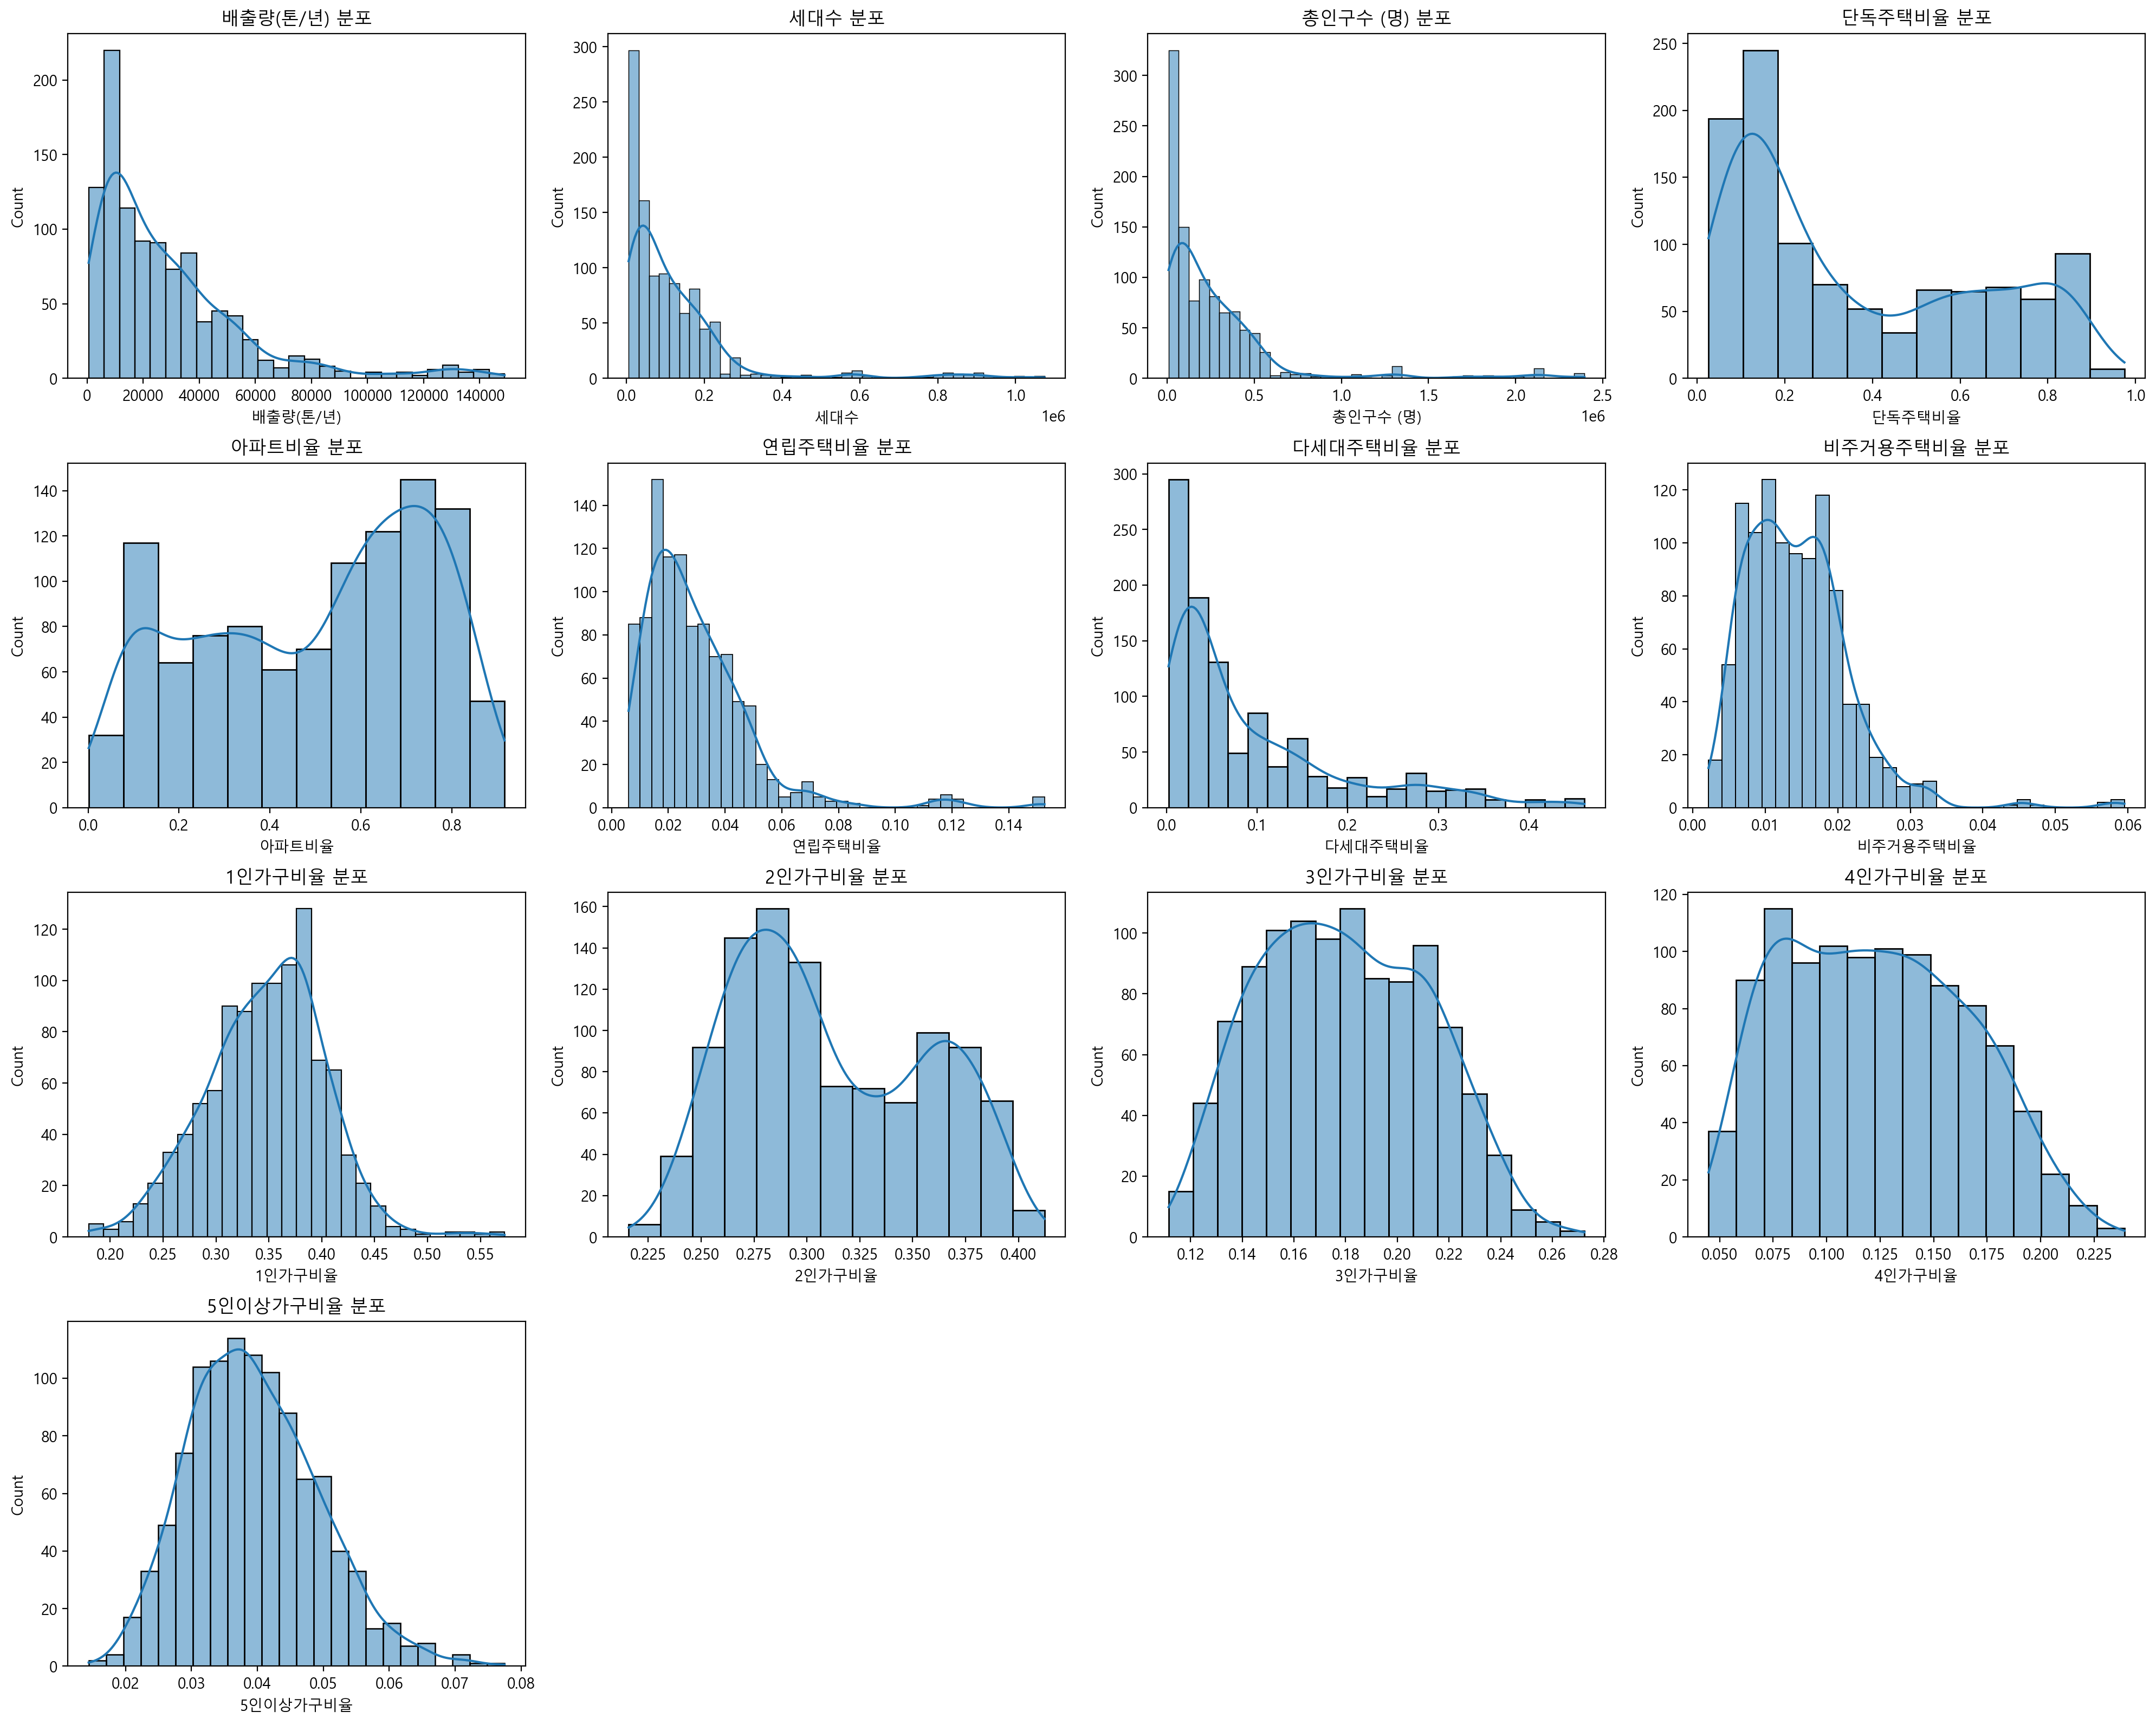

In [25]:
# 변수 리스트
columns_to_plot = [
    '배출량(톤/년)', '세대수', '총인구수 (명)',
    '단독주택비율', '아파트비율', '연립주택비율', '다세대주택비율', '비주거용주택비율',
    '1인가구비율', '2인가구비율', '3인가구비율', '4인가구비율', '5인이상가구비율'
]

# layout 설정: 3행 5열 = 총 15개 (5열 기준)
n_cols = 4
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # 필요한 행 수 자동 계산

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(data=df_drop, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} 분포')
    
# 빈 칸 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

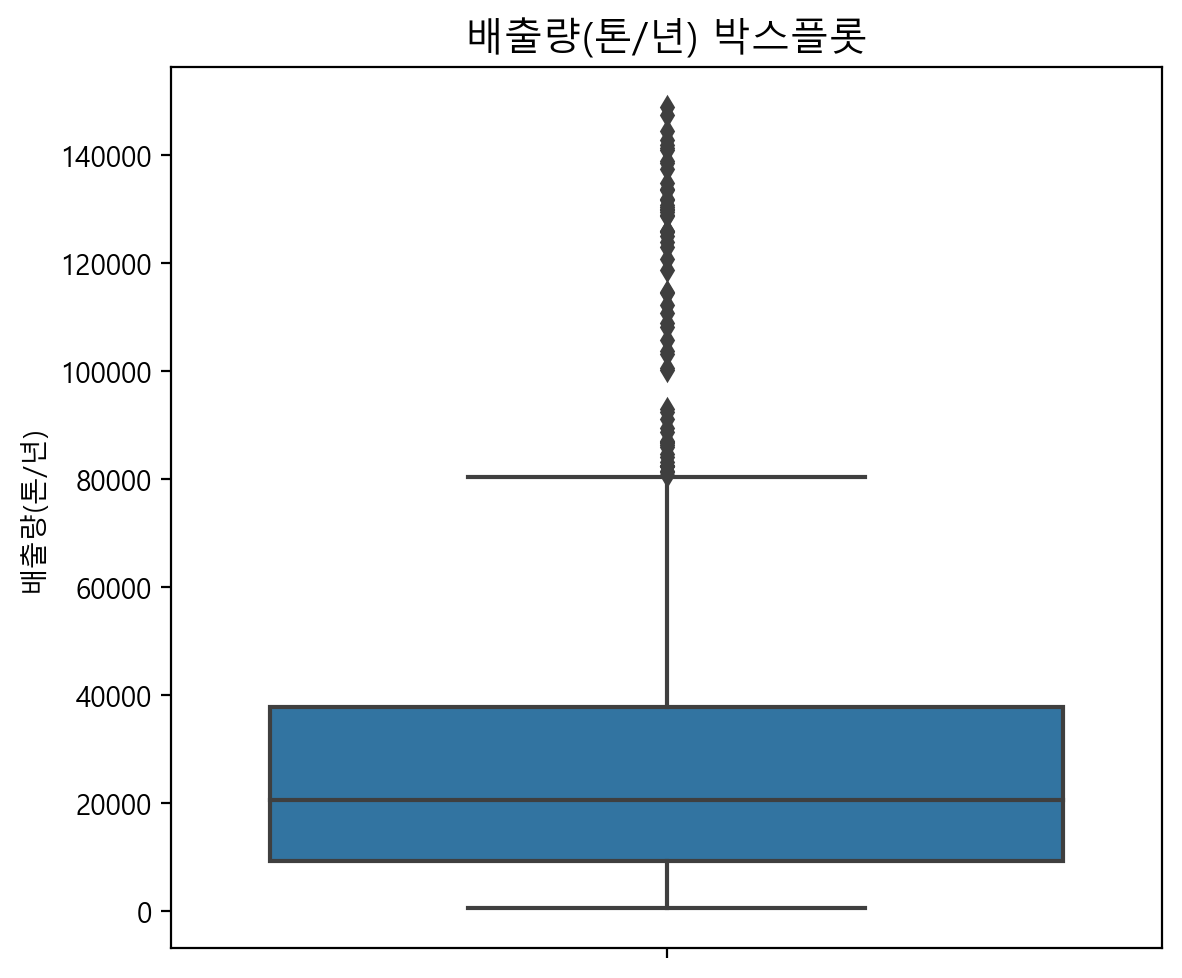

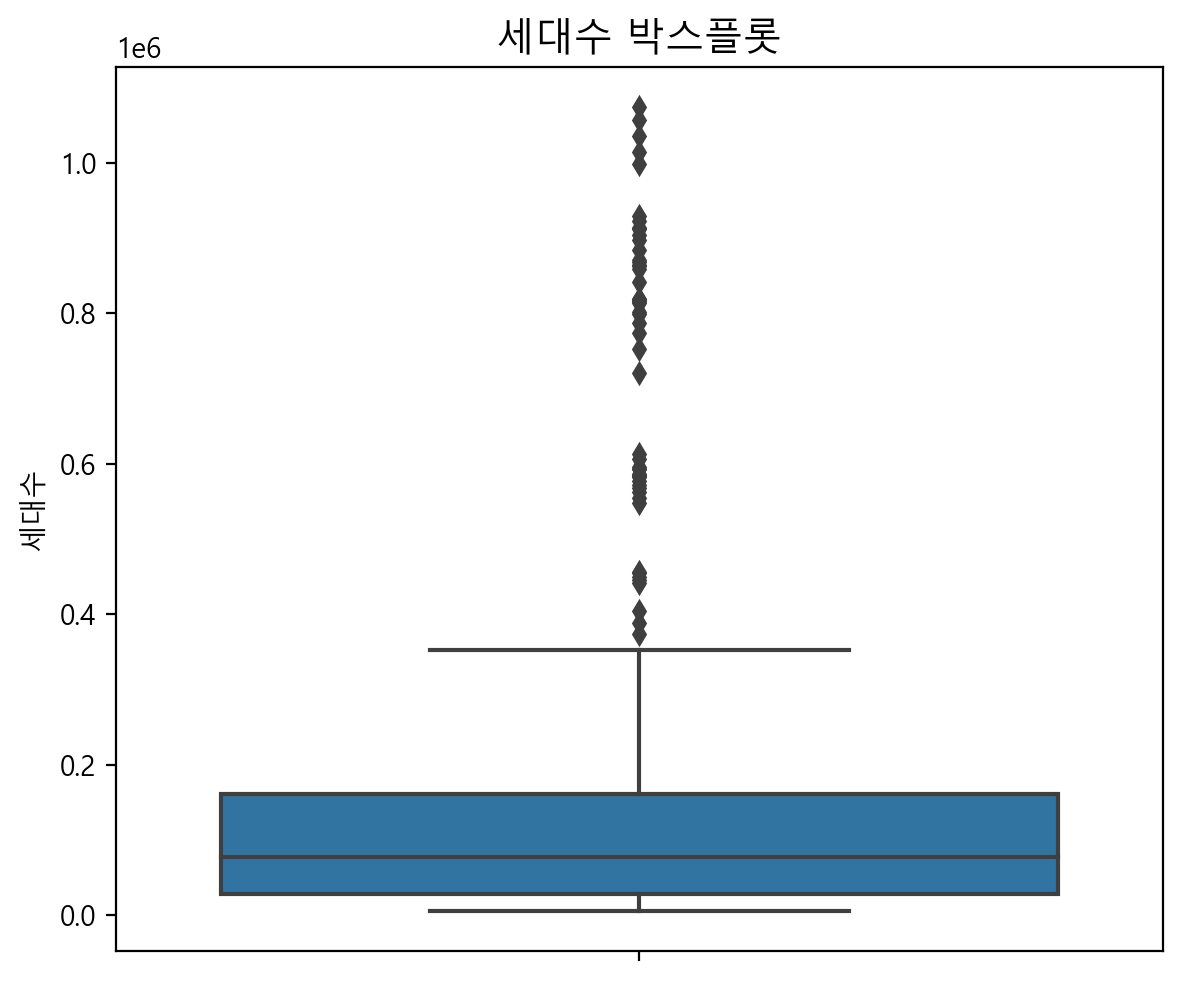

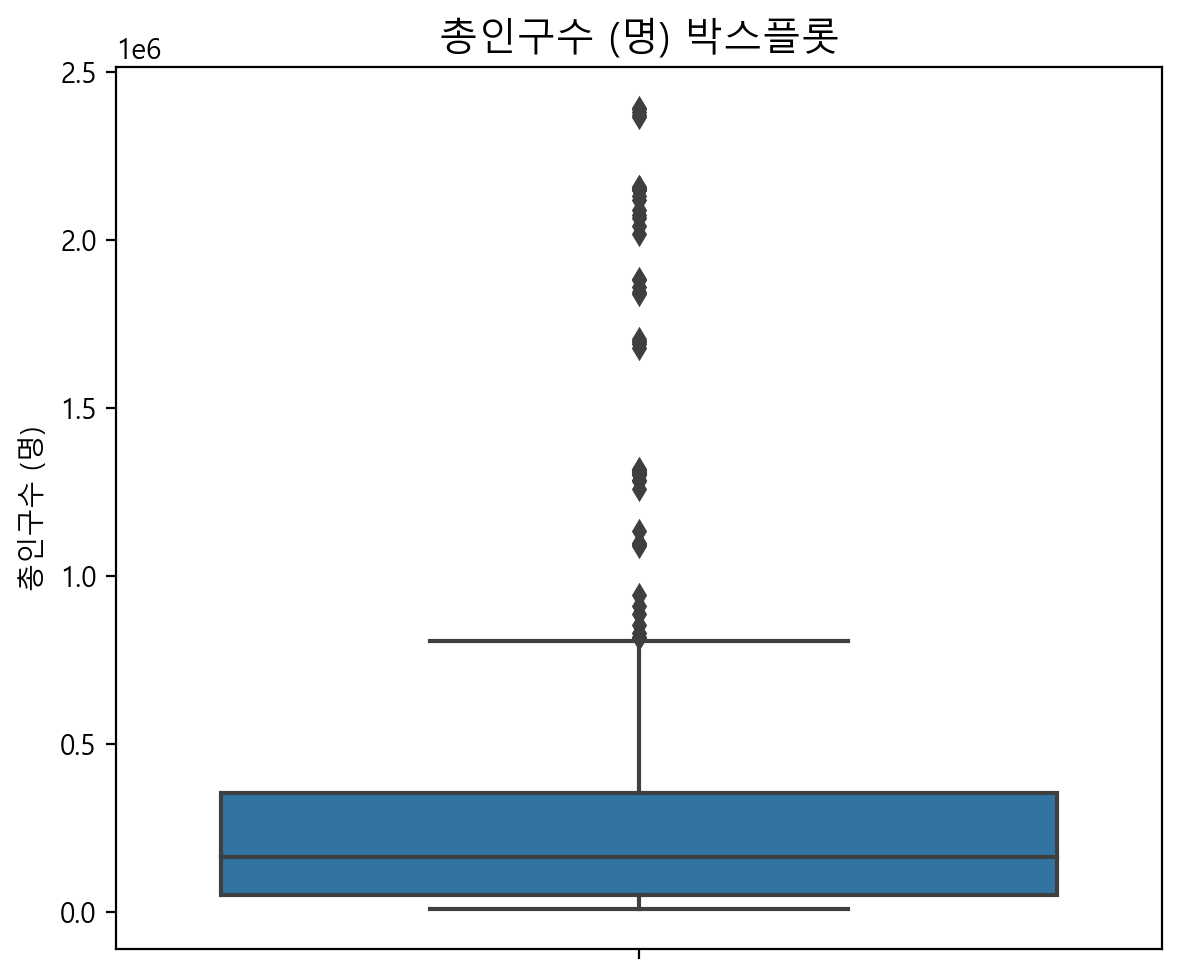

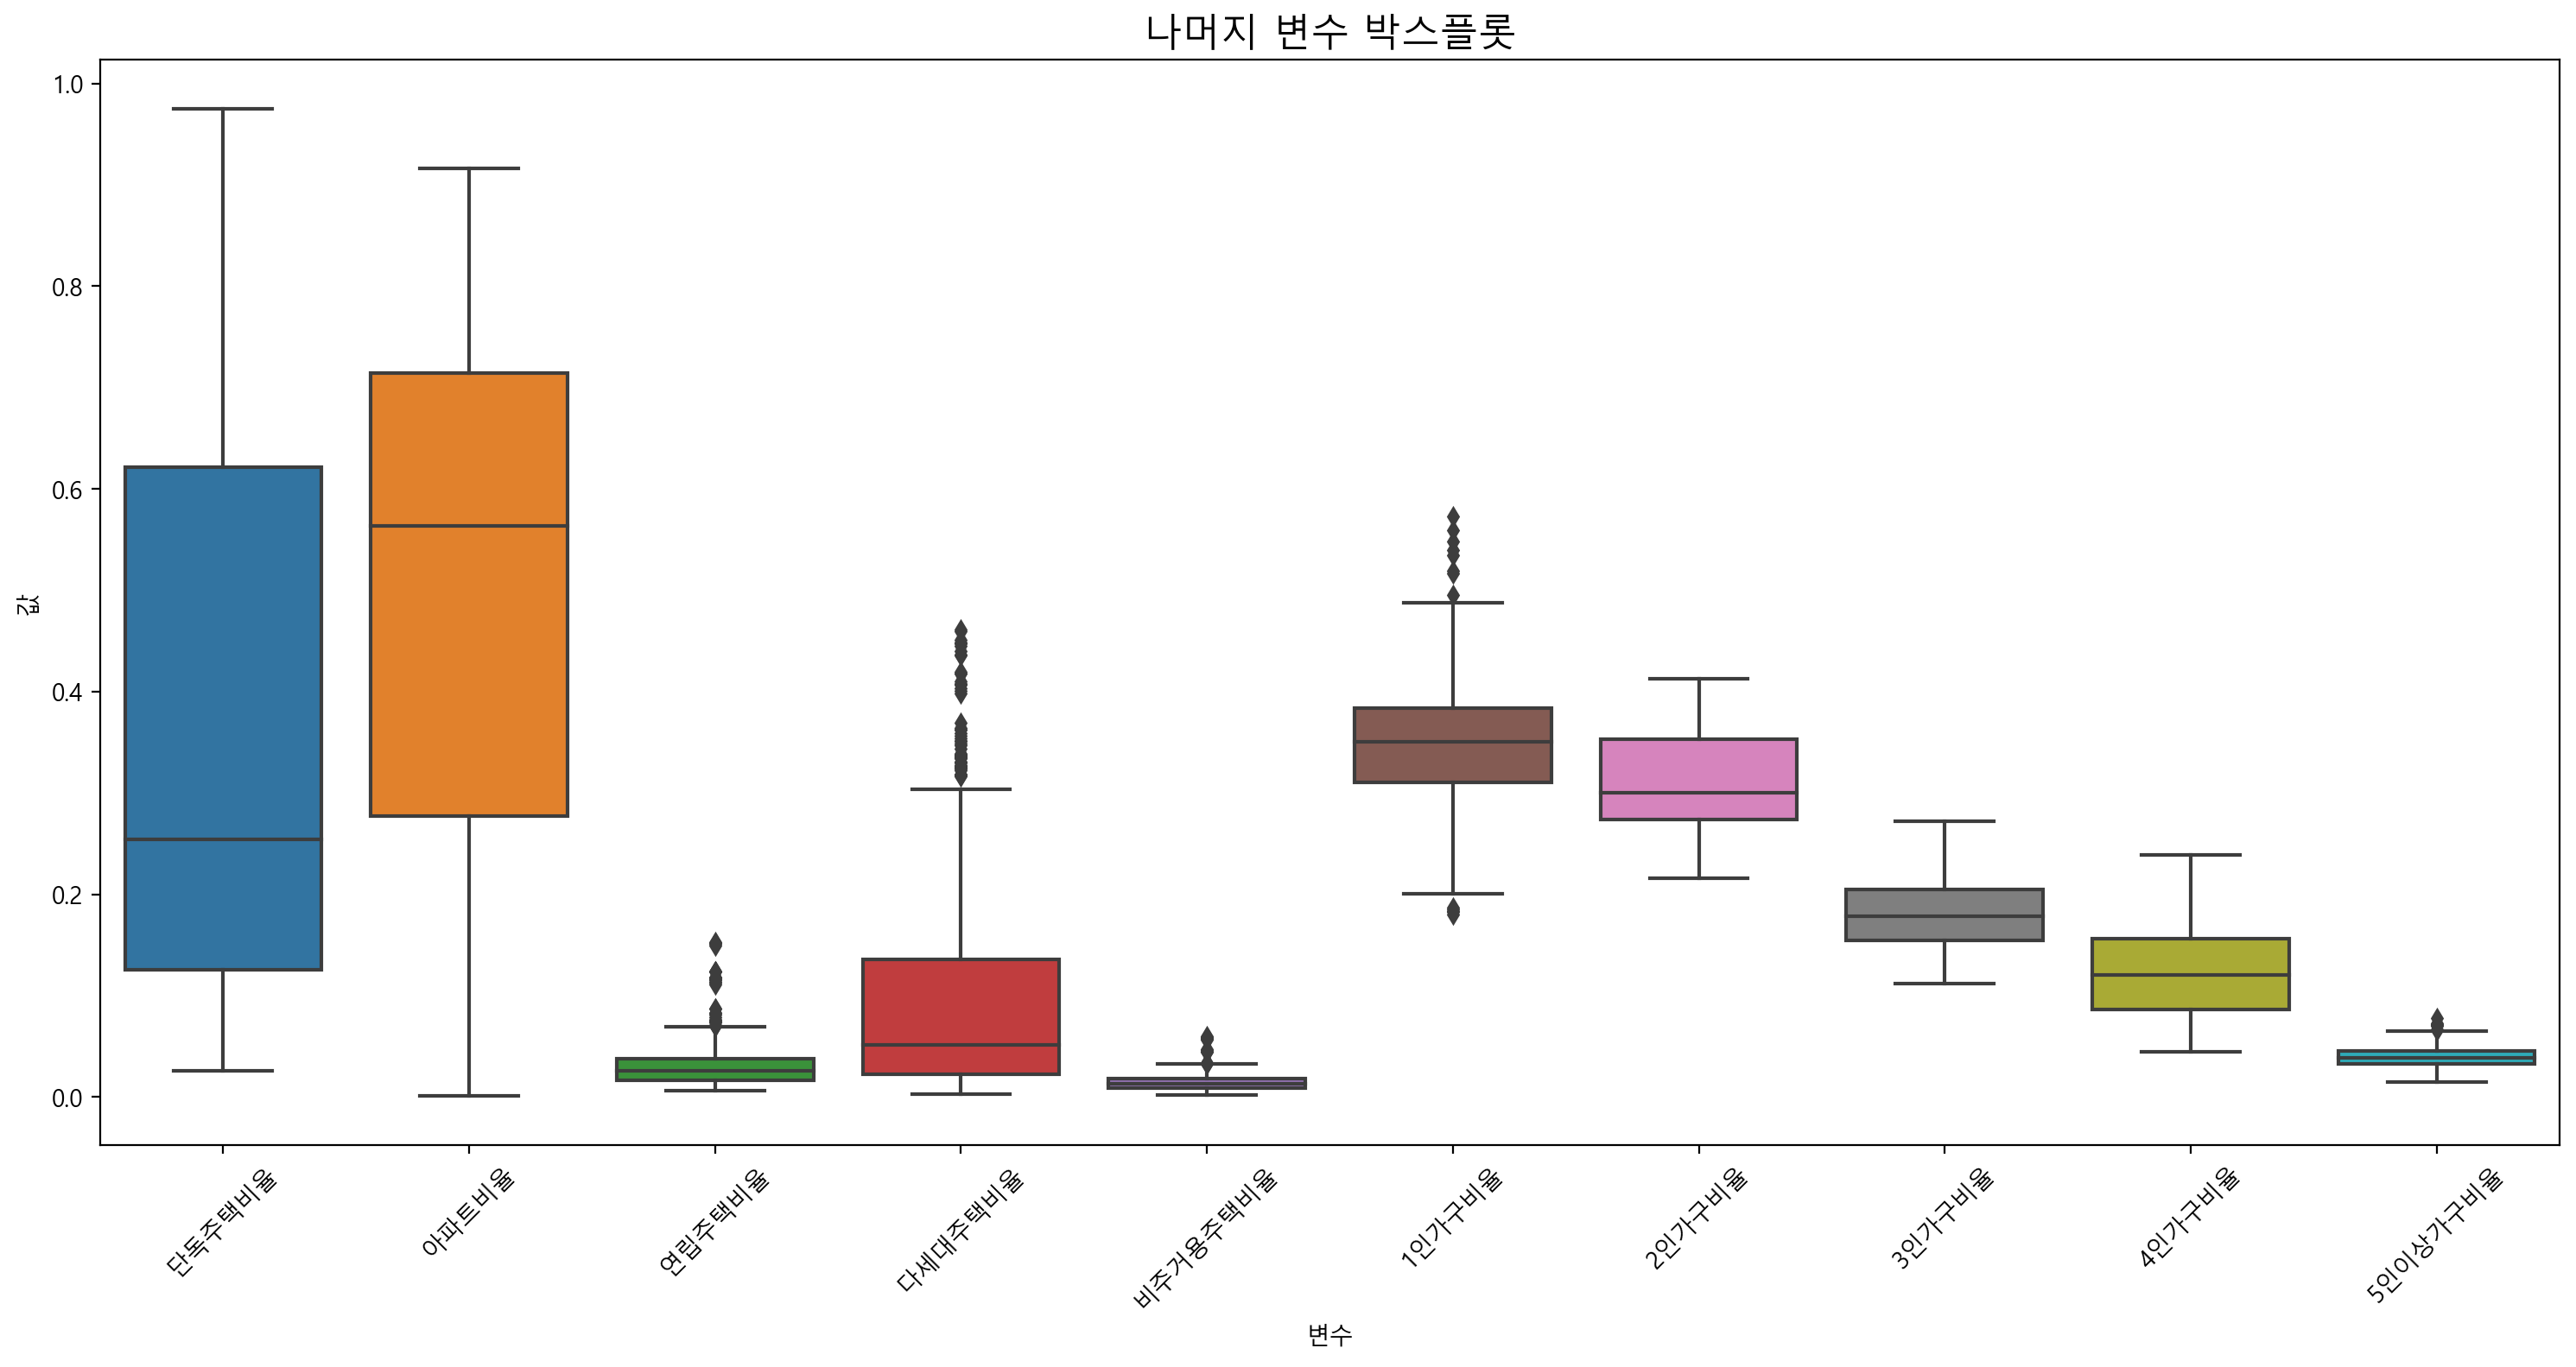

In [27]:
main_columns = ['배출량(톤/년)', '세대수', '총인구수 (명)']
other_columns = [col for col in columns_to_plot if col not in main_columns]

# 개별 박스플롯 (단위가 다른 것들: 배출량, 세대수, 총인구수)
for col in main_columns:
    plt.figure(figsize=(6, 5))
    sns.boxplot(data=df_drop, y=col)
    plt.title(f'{col} 박스플롯', fontsize=14)
    plt.tight_layout()

# 나머지 비율 변수 박스플롯
df_melted_other = df_drop.melt(id_vars=['지역', '연도', '시ㆍ도', '시군구'],
                               value_vars=other_columns, var_name='변수', value_name='값')

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_melted_other, x='변수', y='값')
plt.title('나머지 변수 박스플롯', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

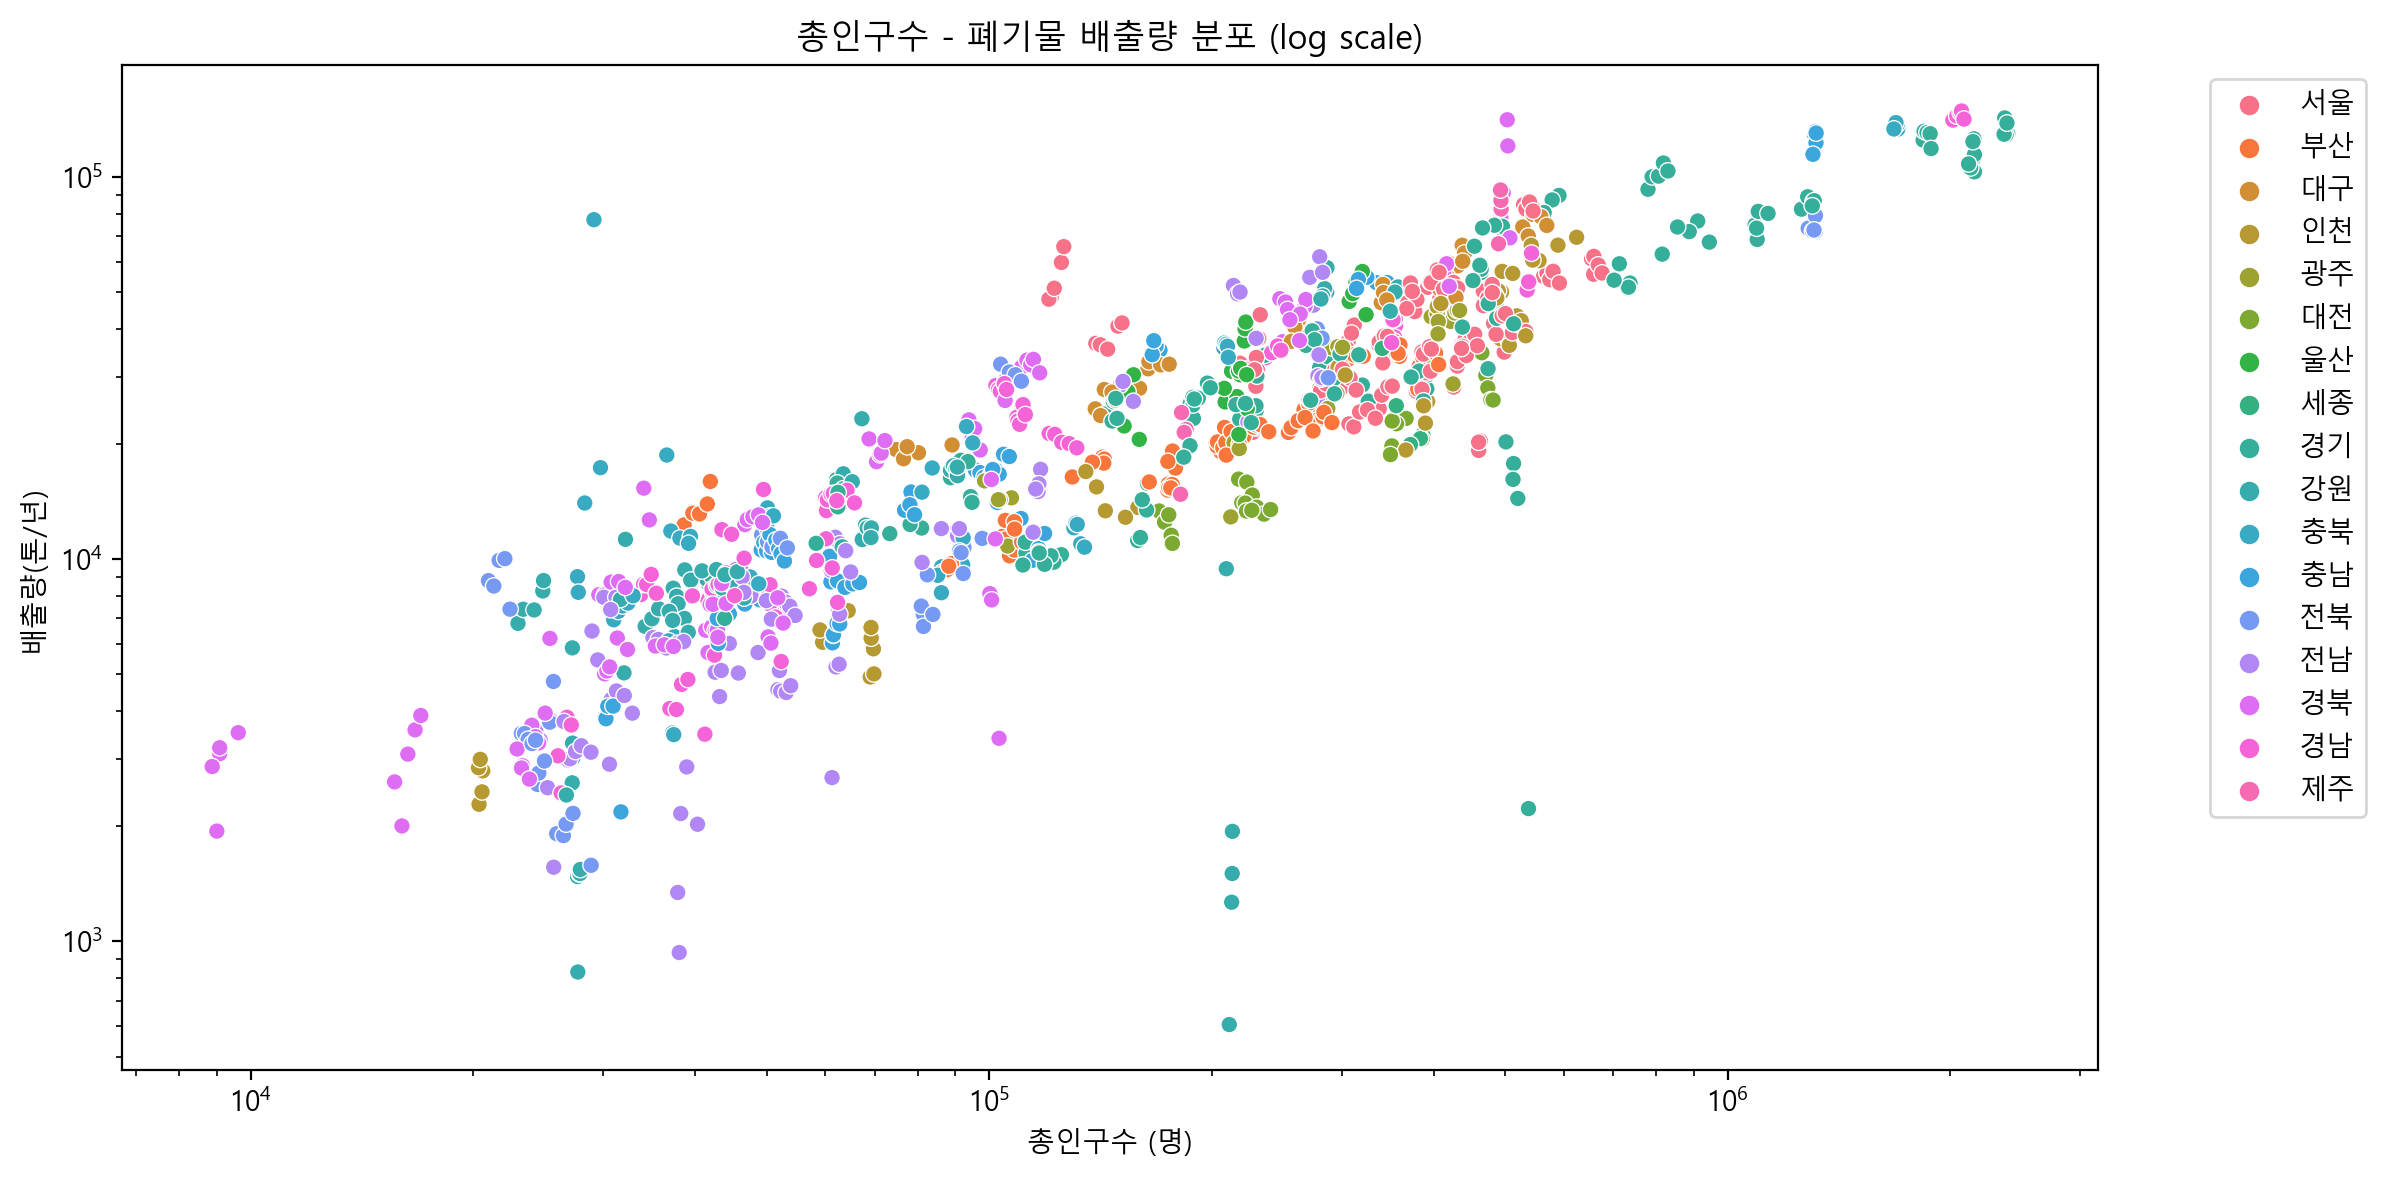

In [28]:
# 확인용 시각화
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=df_drop,
    x='총인구수 (명)',
    y='배출량(톤/년)',
    hue='시ㆍ도'
)

# 로그스케일 설정
plt.xscale('log')
plt.yscale('log')

plt.title('총인구수 - 폐기물 배출량 분포 (log scale)')
plt.xlabel('총인구수 (명)')
plt.ylabel('배출량(톤/년)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [29]:
from matplotlib.patches import Rectangle

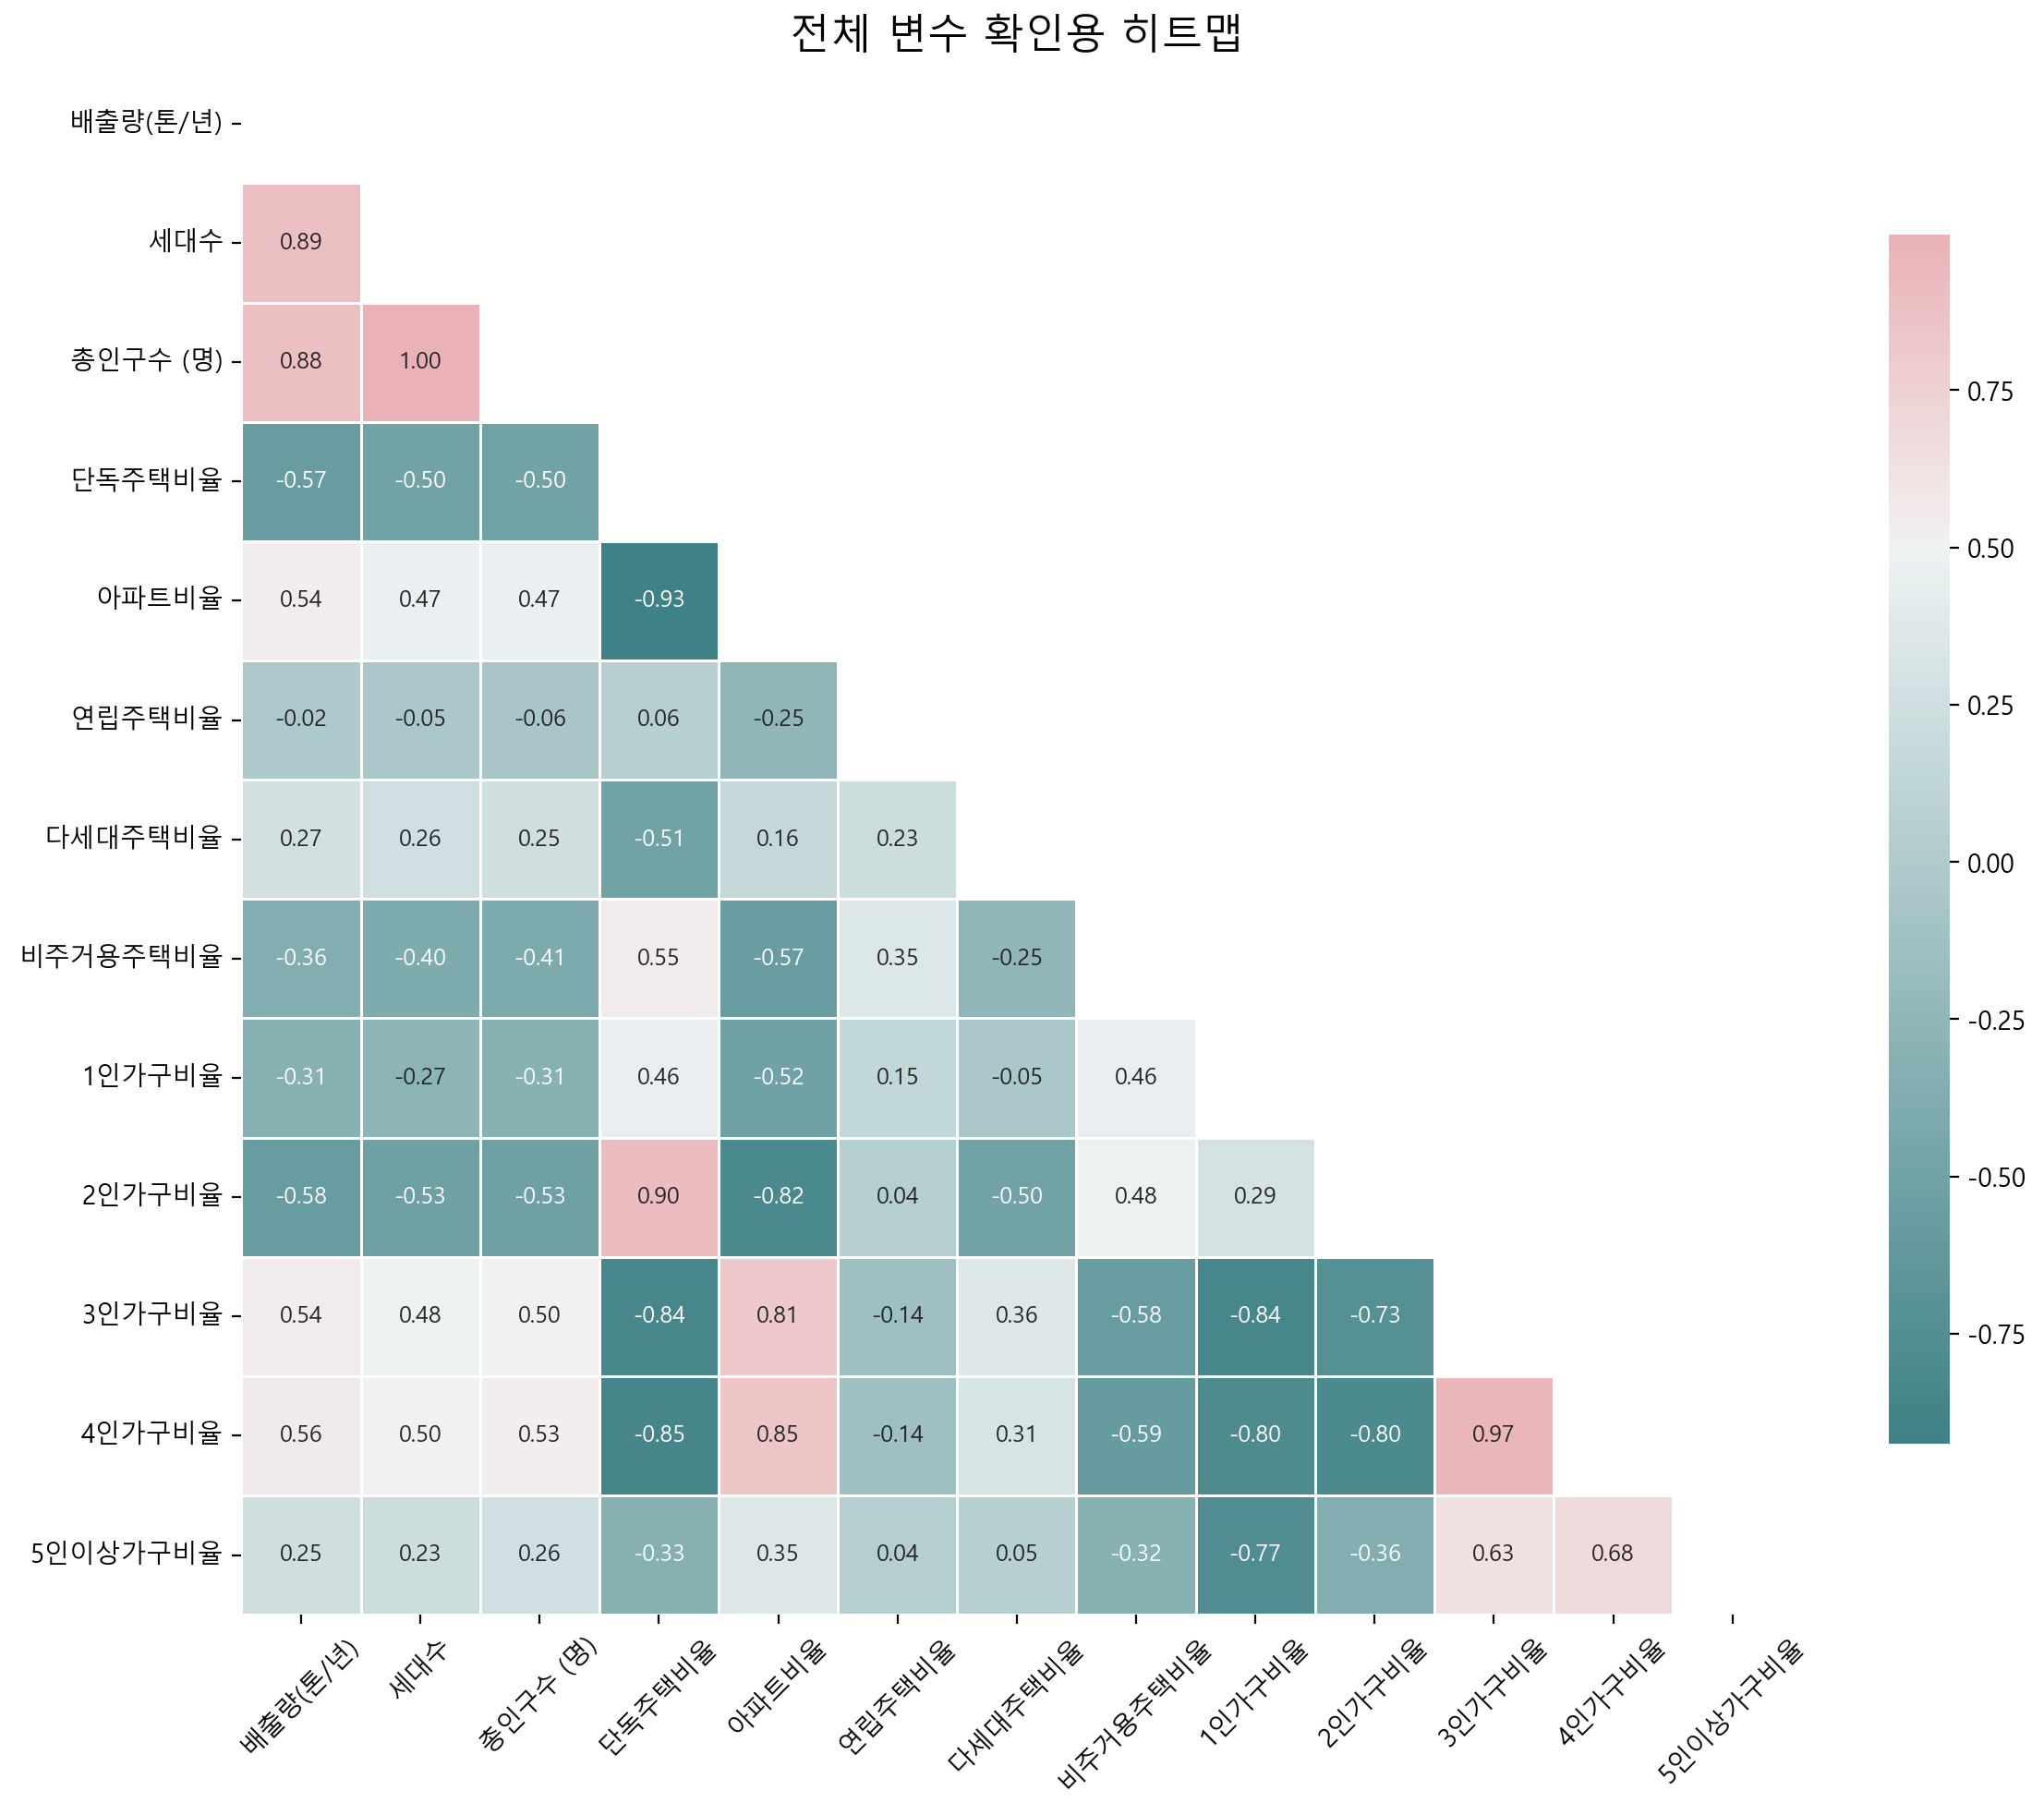

In [33]:
# 상관계수 계산
corr_matrix = df_drop[columns_to_plot].corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# heatmap
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(200, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask,
            cmap=cmap, center=0.5,
            square=True, linewidths=0.5,
            annot=True, annot_kws={"size": 9}, 
            cbar_kws={"shrink": 0.75}, fmt=".2f",)

plt.title('전체 변수 확인용 히트맵', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

<br><br>

---
## 05. 선형회귀 일단 만들어보기
- feature (X) : `세대수`, `총인구수`, `단독주택비율`, `아파트비율`, `연립주택비율`, `다세대주택비율`, `비주거용주택비율`, `1인가구비율`, `2인가구비율`, `3인가구비율`, `4인가구비율`, `5인이상가구비율`

- target (y) : `배출량(톤/년)`

In [63]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

In [64]:
X = df_drop[['세대수', '총인구수 (명)', '단독주택비율', '아파트비율', '연립주택비율', '다세대주택비율',
             '비주거용주택비율', '1인가구비율', '2인가구비율', '3인가구비율', '4인가구비율', '5인이상가구비율']]
y = df_drop['배출량(톤/년)']

In [65]:
# 데이터 분할 (8:2로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# 모델 학습
model = sm.OLS(y_train, X_train_const).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               배출량(톤/년)   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     283.6
Date:                Fri, 13 Jun 2025   Prob (F-statistic):          7.78e-284
Time:                        19:06:19   Log-Likelihood:                -9109.0
No. Observations:                 843   AIC:                         1.824e+04
Df Residuals:                     830   BIC:                         1.831e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.399e+07   8.84e+06     -2.716      0.007   -4.13e+07   -6.65e+06
세대수            0.3809      0.049      7.735      0.000       0.284       0.478
총인구수 (명)      -0.1049      0.021     -4.950      0.000      -0.147      -0.063
단독주택비율      1.402e+07   6.35e+06      2.206      0.028    1.55e+06    2.65e+07
아파트비율       1.403e+07   6.35e+06      2.207      0.028    1.55e+06    2.65e+07
연립주택비율      1.409e+07   6.35e+06      2.217      0.027    1.61e+06    2.66e+07
다세대주택비율     1.401e+07   6.35e+06      2.205      0.028    1.54e+06    2.65e+07
비주거용주택비율    1.432e+07   6.36e+06      2.252      0.025    1.84e+06    2.68e+07
1인가구비율      9.951e+06   6.18e+06      1.610      0.108   -2.18e+06    2.21e+07
2인가구비율      9.972e+06   6.18e+06      1.613      0.107   -2.16e+06    2.21e+07
3인가구비율      9.997e+06   6.19e+06      1.616      0.106   -2.14e+06    2.21e+07
4인가구비율       1.01e+07   6.18e+06      1.634      0.103   -2.03e+06    2.22e+07
5인이상가구비율    9.783e+06   6.18e+06      1.582      0.114   -2.36e+06    2.19e+07
==============================================================================
Omnibus:                      268.296   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1819.856
Skew:                           1.268   Prob(JB):                         0.00
Kurtosis:                       9.737   Cond. No.                     1.95e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 정리

| 항목                    | 의미           | 해석                                        |
| --------------------- | ------------ | ----------------------------------------- |
| R^2: 0.804      | 설명력          | 쓰레기 배출량 변동의 80.4%를 설명 → 높은 설명력 |
| F-statistic: 283.6    | 모델 전체 유의성 검정 | 모델 전체적으로 유의 |
| Prob (F-statistic)    | p-value | 매우 유의한 모델 |


<br>

#### 각 변수별 확인
| 변수         | 계수 (coef)  | p-value | 해석                                                     |
| ---------- | ---------- | ------- | ------------------------------------------------------ |
| const (절편) | -2.399e+07 | 0.007   | 유의미 (p < 0.05)                    |
| 세대수        | +0.3809    | 0.000   | 유의미 → 세대수 1 증가 시 쓰레기 0.38톤 증가 예상                       |
| 총인구수       | -0.1049    | 0.000   | 유의미 → 인구수 1명 증가 시 쓰레기 **0.10톤 감소?????** 예상 |
| 단독주택비율     | +1.402e+07 | 0.028   | 유의미 → 단독주택비율 1 증가(100% → 0%) 시 쓰레기 1,402만 톤 증가         |
| 아파트비율      | +1.403e+07 | 0.028   | 유의미 → 아파트비율 증가 시 쓰레기 증가                                |
| 연립주택비율     | +1.409e+07 | 0.027   | 유의미                                                    |
| 다세대주택비율    | +1.401e+07 | 0.028   | 유의미                                                    |
| 비주거용주택비율   | +1.432e+07 | 0.025   | 유의미                                                    |
| 1인가구비율     | +9.951e+06 | 0.108   | **유의미하지 않음** (p > 0.05)                                    |
| 2인가구비율     | +9.972e+06 | 0.107   | 비유의미                                                   |
| 3인가구비율     | +9.997e+06 | 0.106   | 비유의미                                                   |
| 4인가구비율     | +1.01e+07  | 0.103   | 비유의미                                                   |
| 5인가구비율     | +9.783e+06 | 0.114   | 비유의미                                                   |


In [67]:
y_pred = model.predict(X_test_const)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 105353888.41
R²: 0.89


Text(0.5, 1.0, 'Residuals Histogram')

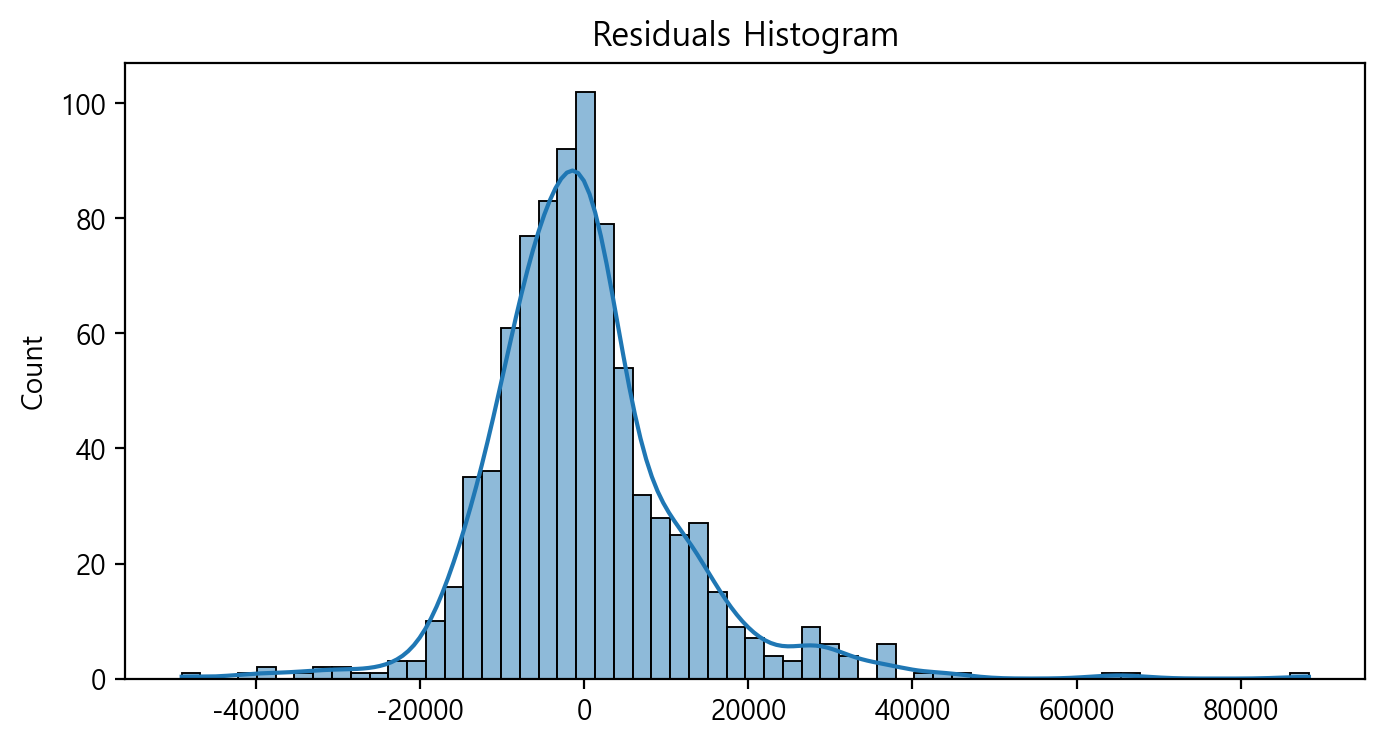

In [69]:
# 학습 데이터의 예측값
y_train_pred = model.predict(X_train_const)
residuals = y_train - y_train_pred

# 잔차 히스토그램
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')

Text(0.5, 1.0, 'Q-Q plot of residuals (scipy)')

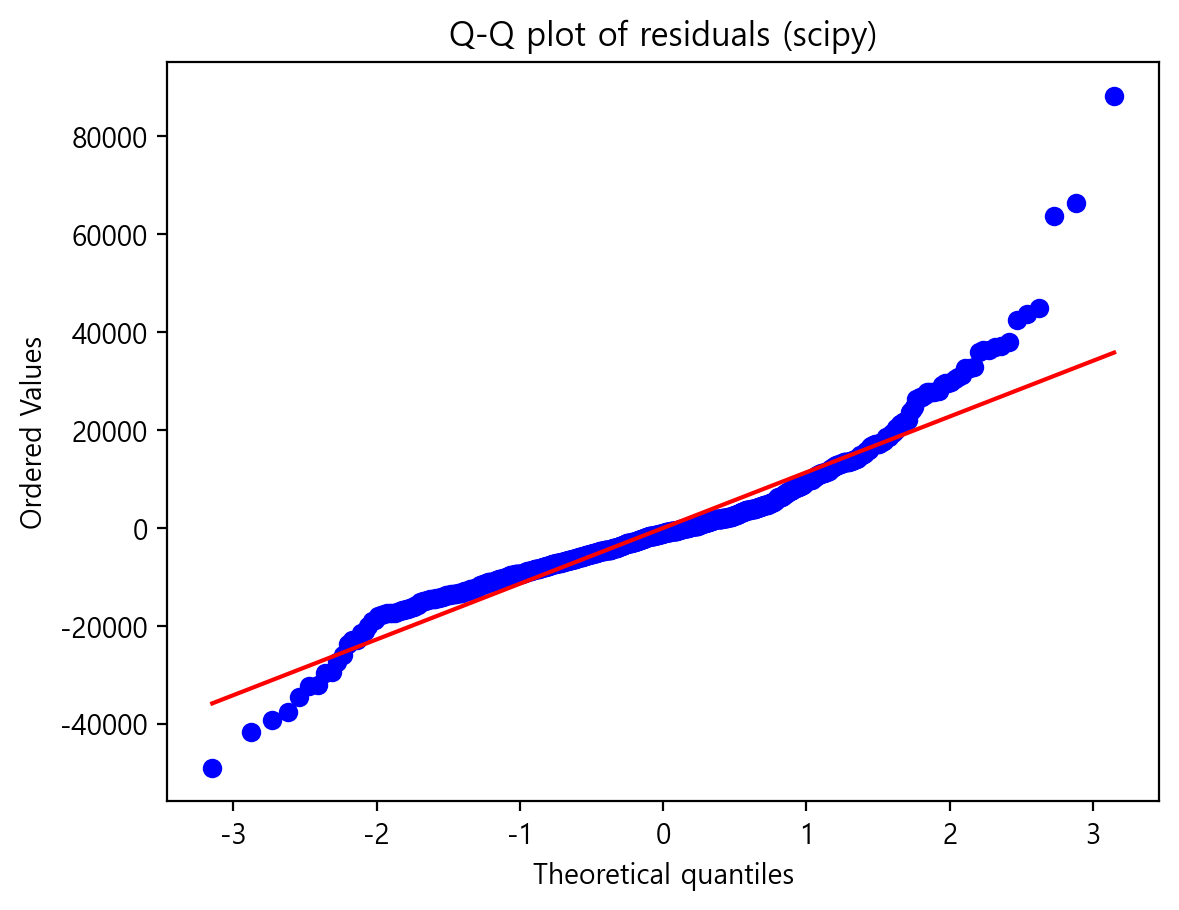

In [70]:
# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot of residuals (scipy)")